# Image segmentation via U-Net
 https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Hyperparameters

In [ ]:
LEARNING_RATE = .001
EPOCHS = 20
BATCH_SIZE = 64
POOLING_TYPE = ['MP', 'AP'] # Max-Pooling, Average Pooling, Global Max Pooling, Global Average Pooling
STRIDE = 1
DROPOUT_RATE = .3

## Helper Functions


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask


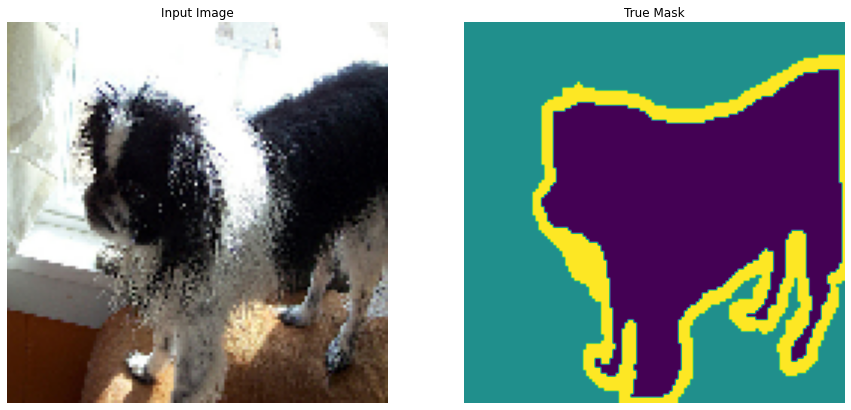

In [ ]:

train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


def downsample_block(x, n_filters, pooling_type='MP'):
  f = double_conv_block(x, n_filters)
  
  if pooling_type == 'MP':
    p = layers.AveragePooling2D(2)(f)

  elif pooling_type == 'AP':
    p = layers.AveragePooling2D(2)(f)
  g = layers.Dropout(DROPOUT_RATE)(p)

  return f,g


def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(DROPOUT_RATE)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def residual_block(input, input_channels, output_channels, num_channels, strides = STRIDE):
  """
  Input
  conv
  batch norm
  conv
  batchnorm
  concatenate
  """
  out = layers.Conv2D(input, kernel_size=3, strides = strides)
  out = layers.Conv2D(out, kernel_size=3, strides = strides)
  out = layers.BatchNormalization()(out)
  out = layers.Conv2D(input, kernel_size=3, strides = strides)
  out = layers.Conv2D(out, kernel_size=3, strides = strides)
  out = layers.BatchNormalization()(out)
  return out



In [ ]:
def build_unet_model(): # inputs
   inputs = layers.Input(shape=(128,128,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

# Training the Model

In [ ]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
57/57 [==============================] - 84s 1s/step - loss: 0.9128 - accuracy: 0.5784 - val_loss: 0.7548 - val_accuracy: 0.6141
Epoch 2/20
14/57 [======>.......................] - ETA: 33s - loss: 0.8379 - accuracy: 0.5894

KeyboardInterrupt: ignored

In [ ]:
save_str = '/content/drive/Shareddrives/CSE_598_Team_Project/Models/unet_model/'
unet_model = unet_model.save(save_str)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/CSE_598_Team_Project/Models/unet_model/assets


INFO:tensorflow:Assets written to: /content/drive/Shareddrives/CSE_598_Team_Project/Models/unet_model/assets


In [ ]:
! ls /content/drive/Shareddrives/CSE_598_Team_Project/Models/


unet_model


# Running the Model

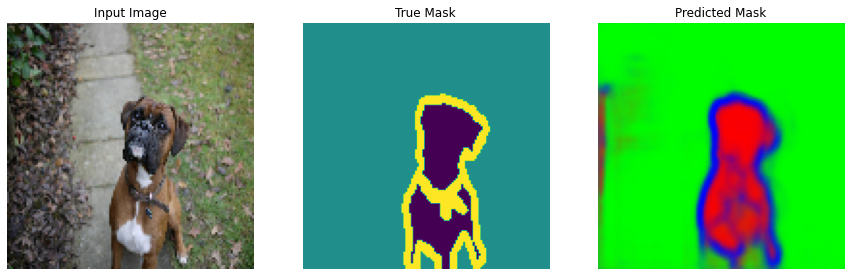

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model = keras.models.load_model(save_str)
idx = np.random.randint(BATCH_SIZE)
'''
image = tf.expand_dims(sample_batch[idx][0], axis=0)
gt = tf.expand_dims(sample_batch[idx][1], axis=0)

def display():
    figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(tf.squeeze(image))
    ax1.set_title("Input Image")
    ax2.imshow(tf.squeeze(output))
    ax2.set_title("Output Mask")
'''
output = model.predict(tf.expand_dims(sample_image, axis=0))
output = tf.squeeze(output)
display([sample_image, sample_mask, output]) # TODO: return max color for each pixel w.r.t. ea. channel to get rid of faded mask